In [14]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Monta o Google Drive
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

def get_model(num_classes, weights_path):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )

    # Load the state dict
    state_dict = torch.load(weights_path, map_location=device)

    # Remove the '_orig_mod.' prefix from the keys if present
    # This is necessary if the model was saved after being wrapped (e.g., by torch.jit.script)
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            new_state_dict[k[len('_orig_mod.'):]] = v
        else:
            new_state_dict[k] = v

    # Load the modified state dict
    model.load_state_dict(new_state_dict)
    model = model.to(device)
    model.eval()
    return model

def predict_image(model, image_path, class_names, transform):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
    pred_class = class_names[predicted.item()]
    return pred_class, confidence.item()


In [16]:
def predict_single_image(model, class_names, transform, image_path):
    prediction, confidence = predict_image(model, image_path, class_names, transform)
    print(f"Imagem: {os.path.basename(image_path)} → Predição: {prediction} ({confidence*100:.2f}%)")
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predição: {prediction} ({confidence*100:.2f}%)')
    plt.axis('off')
    plt.show()


def predict_directory(model, class_names, transform, dir_path):
    for file in sorted(os.listdir(dir_path)):
        file_path = os.path.join(dir_path, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
            predict_single_image(model, class_names, transform, file_path)


In [17]:
# Caminho para os pesos do modelo
weights_path = '/content/drive/MyDrive/doutorado/model_weights/resnet18_fold1.pth'

# Lista das classes
class_names = ['angiografia fluoresceínica',
               'fixacao de biometria',
               'fixacao de biometria 2',
               'oct de segmento anterior',
               'oct macular',
               'relatorio de retinografia colorida',
               'retinografia em autofluorescencia',
               'retinografia fundo de olho',
               'tonometria']

# Inicialização
transform = get_transforms()
model = get_model(num_classes=len(class_names), weights_path=weights_path)


Imagem: CLARUS 700_exam_453625_file_2369823..jpg → Predição: retinografia fundo de olho (99.89%)


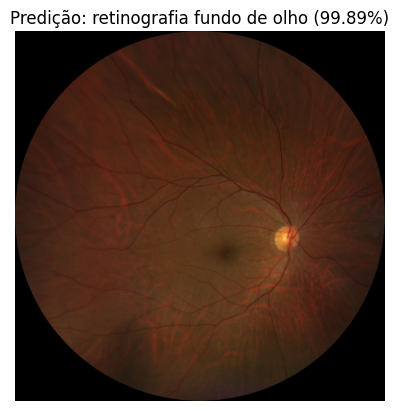

In [18]:
predict_single_image(model, class_names, transform, '/content/teste/CLARUS 700_exam_453625_file_2369823..jpg')


Imagem: type not found_exam_2458890_file_4273236.jpg → Predição: retinografia fundo de olho (99.15%)


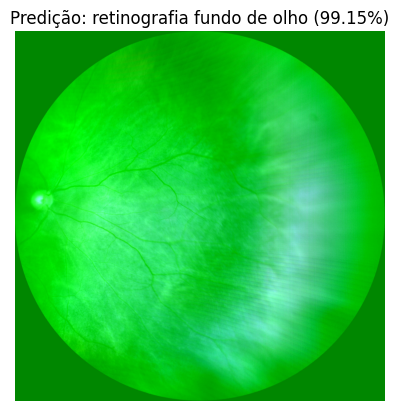

In [19]:
predict_single_image(model, class_names, transform, '/content/teste/type not found_exam_2458890_file_4273236.jpg')

Imagem: CIRRUS HD-OCT 500_exam_527550_file_2439542..jpg → Predição: oct macular (97.02%)


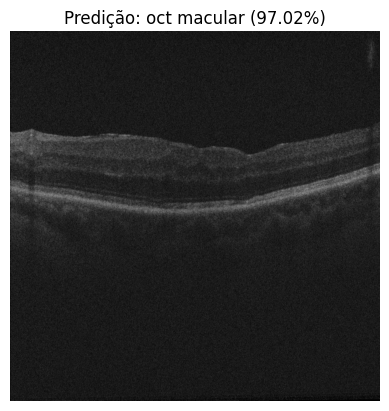

Imagem: CIRRUS HD-OCT 6000_exam_412341_file_2329142 - Copia.jpg → Predição: retinografia em autofluorescencia (97.39%)


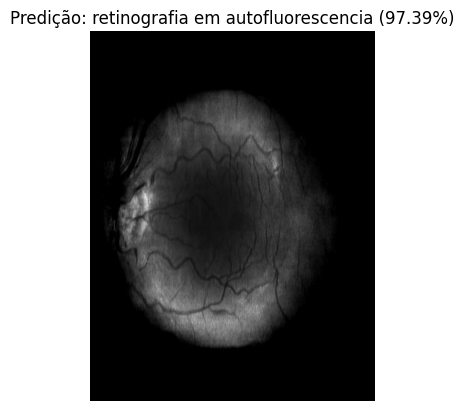

Imagem: CLARUS 700_exam_453625_file_2369823..jpg → Predição: retinografia fundo de olho (99.89%)


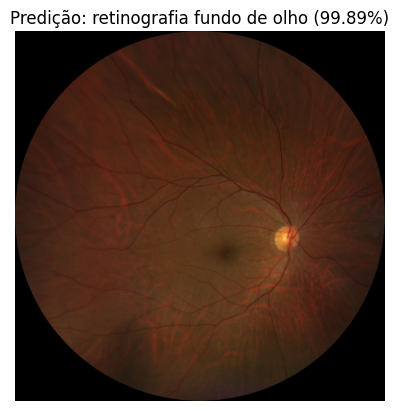

Imagem: IOLMaster 700_exam_401785_file_2318589.jpg → Predição: fixacao de biometria 2 (99.30%)


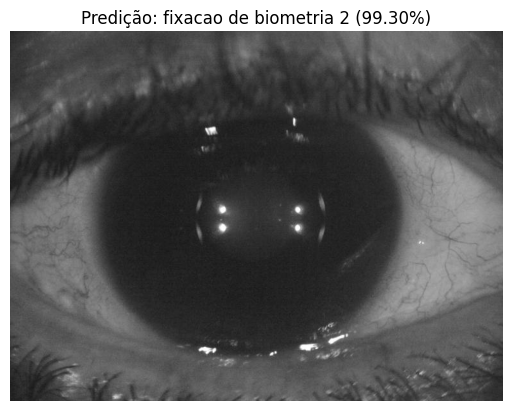

Imagem: IOLMaster 700_exam_429590_file_2346204. - Copia.jpg → Predição: oct de segmento anterior (93.32%)


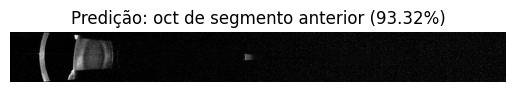

Imagem: type not found_exam_2458890_file_4273236.jpg → Predição: retinografia fundo de olho (99.15%)


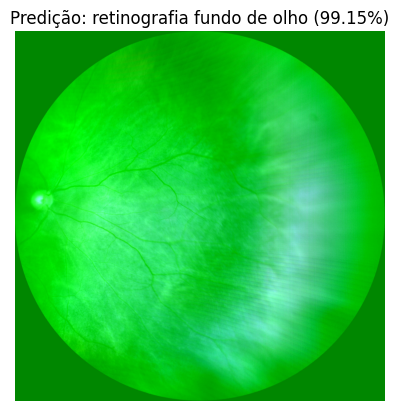

In [20]:
predict_directory(model, class_names, transform, '/content/teste/')

Imagem: atestado.jpg → Predição: angiografia fluoresceínica (64.71%)


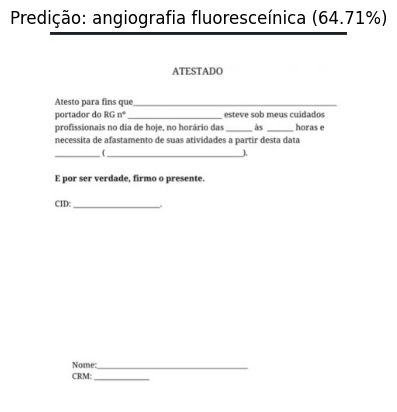

Imagem: careca.jpg → Predição: retinografia em autofluorescencia (40.51%)


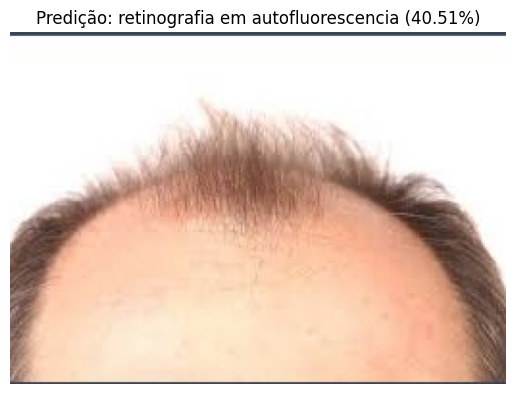

Imagem: carteira de identidade.jpg → Predição: angiografia fluoresceínica (69.21%)


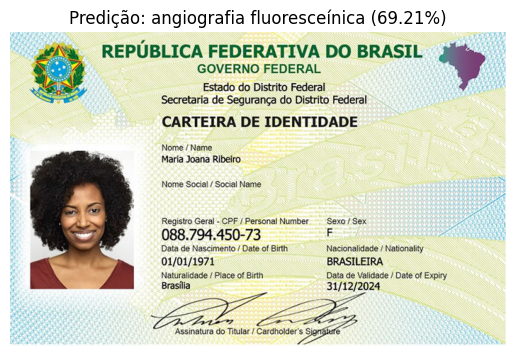

Imagem: rx_mao.jpg → Predição: angiografia fluoresceínica (82.50%)


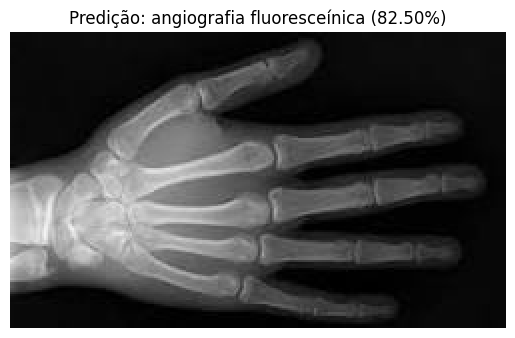

In [21]:
predict_directory(model, class_names, transform, '/content/imagens erradas/')